In [109]:
import json

#import numpy as np
import pandas as pd
import pymongo
import scipy

from bson import ObjectId, json_util
from pandas.io.json import json_normalize
from pymongo import MongoClient as Connection
from scipy import sparse, spatial
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

# scientific notation disabled form smaller numbers
pd.options.display.float_format = '{:.2f}'.format

# alles resultate anzeigen und nicht nur das letzte
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [110]:
# display multiple outputs in one row
import pandas as pd
import numpy as np
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [111]:
connection = Connection()
db = connection.recipe_db
input_data = db.recipes_test_copy

data = json.loads(json_util.dumps(input_data.find()))
norm_data = json_normalize(data)


In [112]:
ing = pd.DataFrame(json_normalize(data, record_path='ingredients',
                             meta='id', record_prefix='ingredients_', errors='ignore'))


nutritions = pd.DataFrame(json_normalize(data, record_path='nutritions',
                            meta=['id', 'prep_time', 'rating', 'rating_count', 'ready_in_time', 'review_count']))


In [113]:
desc = norm_data.describe().loc[['mean','std', 'min', 'max', '50%']]

In [114]:
norm_data.describe()

,id,authorId,prep_time,cook_time,ready_in_time,servings,rating,rating_count,review_count,made_it_count
count,6304.00,6304.00,6304.00,6304.00,6304.00,6304.00,6304.00,6304.00,6304.00,6304.00
mean,92184.39,1852314.30,17.10,59.21,109.30,4.00,4.36,252.94,189.32,372.13
std,83170.15,3691577.20,32.04,105.29,253.23,0.00,0.28,490.71,353.85,761.33
min,6806.00,0.00,0.00,0.00,0.00,4.00,2.00,2.00,1.00,5.00
25%,19362.50,0.00,10.00,15.00,30.00,4.00,4.20,58.00,45.00,75.00
50%,58815.00,471714.00,15.00,30.00,50.00,4.00,4.40,105.00,82.00,142.50
75%,167983.25,1872628.50,20.00,50.00,90.00,4.00,4.56,228.25,175.00,332.00
max,263813.00,22212574.00,1500.00,1500.00,10290.00,4.00,5.00,7898.00,5588.00,14356.00


In [115]:
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})

In [116]:
#ausreißer entfernen (die im bereich größer 2 standardabwechungen liegen)
from scipy import stats
norm_data_no_outliers = norm_data

asd = norm_data_no_outliers[(np.abs(stats.zscore(norm_data_no_outliers.cook_time)) < 2)]

In [117]:
asd

,categories,name,id,authorId,author,description,prep_time,cook_time,ready_in_time,servings,rating,rating_count,review_count,made_it_count,api_url,url,ingredients,nutritions,_id.$oid
0,"[{'name': 'Vegetarian'}, {'name': 'Casserole'}...",Spinach Enchiladas,59661,662842,SADONIA2,"If you like spinach and Mexican food, you'll l...",20,20,40,4,4.34,1180,817,2267,https://apps.allrecipes.com/v1/recipes/59661,https://www.allrecipes.com/recipe/59661/spinac...,"[{'id': 16157, 'name': '10 g butter', 'grams':...","[{'name': 'Fat', 'amount': 35.95846, 'unit': '...",5b2257a5ff20008b5a00085d
1,"[{'name': 'Gluten Free'}, {'name': 'Dairy Free...",Stuffed Peppers,16330,25072,BDEGER,Green peppers stuffed with ground beef and ric...,20,60,80,4,4.29,1605,1111,2687,https://apps.allrecipes.com/v1/recipes/16330,https://www.allrecipes.com/recipe/16330/stuffe...,"[{'id': 3103, 'name': '305 g ground beef', 'gr...","[{'name': 'Fat', 'amount': 9.378057, 'unit': '...",5b2257acff20008b5a00085e
2,"[{'name': 'Chicken'}, {'name': 'Main'}, {'name...",Crispy and Tender Baked Chicken Thighs,235151,2032612,Nicole Burdett,A simple spice blend gives tons of flavor to t...,10,60,70,4,4.64,1007,786,3923,https://apps.allrecipes.com/v1/recipes/235151,https://www.allrecipes.com/recipe/235151/crisp...,"[{'id': 10536, 'name': 'cooking spray', 'grams...","[{'name': 'Fat', 'amount': 11.88371, 'unit': '...",5b2257b0ff20008b5a00085f
3,"[{'name': 'Quick Easy'}, {'name': 'Chicken'}, ...",Simple Baked Chicken Breasts,240208,196935,Always Cooking Up Something,Simple basic recipe for cooking up a bunch of ...,15,25,40,4,4.61,282,204,2116,https://apps.allrecipes.com/v1/recipes/240208,https://www.allrecipes.com/recipe/240208/simpl...,"[{'id': 6494, 'name': '4 skinless, boneless ch...","[{'name': 'Fat', 'amount': 9.5803, 'unit': 'g'...",5b2257b4ff20008b5a000860
4,"[{'name': 'Easter'}, {'name': 'Salad'}, {'name...",Delicious Egg Salad for Sandwiches,147103,2309128,wifeyluvs2cook,This is a wonderful-tasting egg salad sandwich...,10,15,35,4,4.62,1475,1027,3046,https://apps.allrecipes.com/v1/recipes/147103,https://www.allrecipes.com/recipe/147103/delic...,"[{'id': 16317, 'name': '8 eggs', 'grams': 400....","[{'name': 'Fat', 'amount': 31.85464, 'unit': '...",5b2257bdff20008b5a000861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6298,"[{'name': 'Health'}, {'name': 'Casserole'}, {'...",Smoky Chipotle Mac and Cheese,228431,3080394,blancdeblanc,Adding chipotle chiles to this macaroni and ch...,10,35,45,4,4.83,36,30,152,https://apps.allrecipes.com/v1/recipes/228431,https://www.allrecipes.com/recipe/228431/smoky...,"[{'id': 1701, 'name': '300 g elbow macaroni', ...","[{'name': 'Fat', 'amount': 36.52755, 'unit': '...",5b238619ff20008b5a0020f8
6299,"[{'name': 'BBQ'}, {'name': 'Beef'}, {'name': '...",Miso-Glazed Skirt Steak,228049,8601924,Chef John,This succulent grilled skirt steak recipe woul...,10,8,48,4,4.14,36,28,82,https://apps.allrecipes.com/v1/recipes/228049,https://www.allrecipes.com/recipe/228049/miso-...,"[{'id': 18888, 'name': '45 ml red wine vinegar...","[{'name': 'Fat', 'amount': 7.365764, 'unit': '...",5b23861bff20008b5a0020f9
6301,"[{'name': 'Asian'}, {'name': 'Chicken'}, {'nam...",Chef John's Chicken Satay Burger,236032,8601924,Chef John,"I love chicken satay, that spicy meat on a sti...",15,20,35,4,4.81,36,26,53,https://apps.allrecipes.com/v1/recipes/236032,https://www.allrecipes.com/recipe/236032/chef-...,"[{'id': 2858, 'name': '35 g peanut butter', 'g...","[{'name': 'Fat', 'amount': 8.863402, 'unit': '...",5b238622ff20008b5a0020fb
6302,"[{'name': 'Chicken'}, {'name': 'Main'}, {'name...",Pineapple Jerk Chicken,245877,17095853,Cans Get You Cooking®,Canned pineapple is harvested and packed at it...,10,20,30,4,4.50,36,27,152,https://apps.allrecipes.com/v1/recipes/245877,https://www.allrecipes.com/recipe/245877/pinea...,"[{'id': 1650, 'name': '125 g uncooked long-gra...","[{'name': 'Fat', 'amount': 4.347167, 'unit': '...",5b238629ff20008b5a0020fc


In [118]:
#test auf normalverteilung
from scipy.stats import normaltest
k2, p = normaltest(asd.cook_time)
p
k2

0.0

3506.931340759709

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1432e5cd0>]],
      dtype=object)

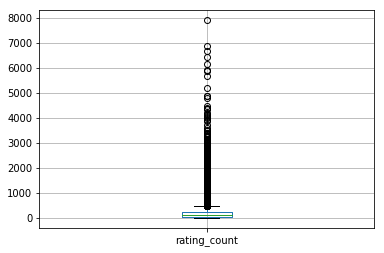

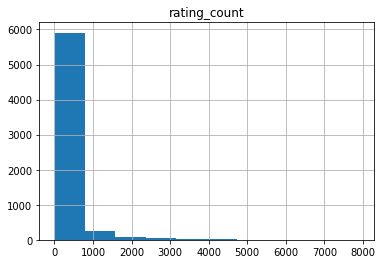

In [119]:
norm_data.boxplot(['rating_count'])
norm_data.hist(column='rating_count', bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x136f67a10>]],
      dtype=object)

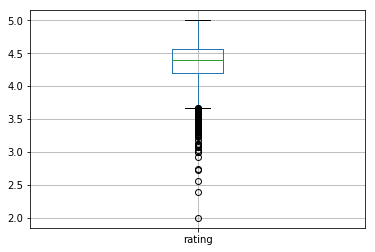

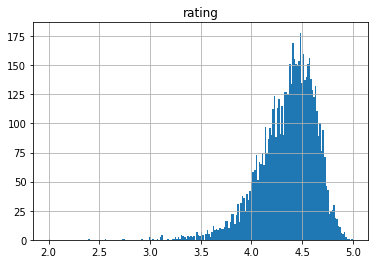

In [120]:
norm_data.boxplot(['rating'])
norm_data.hist(column='rating', bins=200)

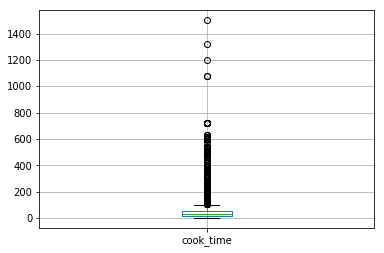

In [121]:

norm_data.boxplot(['cook_time'])

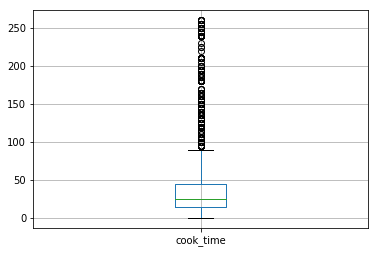

In [122]:
asd.boxplot(['cook_time'])

In [123]:
asd

,categories,name,id,authorId,author,description,prep_time,cook_time,ready_in_time,servings,rating,rating_count,review_count,made_it_count,api_url,url,ingredients,nutritions,_id.$oid
0,"[{'name': 'Vegetarian'}, {'name': 'Casserole'}...",Spinach Enchiladas,59661,662842,SADONIA2,"If you like spinach and Mexican food, you'll l...",20,20,40,4,4.34,1180,817,2267,https://apps.allrecipes.com/v1/recipes/59661,https://www.allrecipes.com/recipe/59661/spinac...,"[{'id': 16157, 'name': '10 g butter', 'grams':...","[{'name': 'Fat', 'amount': 35.95846, 'unit': '...",5b2257a5ff20008b5a00085d
1,"[{'name': 'Gluten Free'}, {'name': 'Dairy Free...",Stuffed Peppers,16330,25072,BDEGER,Green peppers stuffed with ground beef and ric...,20,60,80,4,4.29,1605,1111,2687,https://apps.allrecipes.com/v1/recipes/16330,https://www.allrecipes.com/recipe/16330/stuffe...,"[{'id': 3103, 'name': '305 g ground beef', 'gr...","[{'name': 'Fat', 'amount': 9.378057, 'unit': '...",5b2257acff20008b5a00085e
2,"[{'name': 'Chicken'}, {'name': 'Main'}, {'name...",Crispy and Tender Baked Chicken Thighs,235151,2032612,Nicole Burdett,A simple spice blend gives tons of flavor to t...,10,60,70,4,4.64,1007,786,3923,https://apps.allrecipes.com/v1/recipes/235151,https://www.allrecipes.com/recipe/235151/crisp...,"[{'id': 10536, 'name': 'cooking spray', 'grams...","[{'name': 'Fat', 'amount': 11.88371, 'unit': '...",5b2257b0ff20008b5a00085f
3,"[{'name': 'Quick Easy'}, {'name': 'Chicken'}, ...",Simple Baked Chicken Breasts,240208,196935,Always Cooking Up Something,Simple basic recipe for cooking up a bunch of ...,15,25,40,4,4.61,282,204,2116,https://apps.allrecipes.com/v1/recipes/240208,https://www.allrecipes.com/recipe/240208/simpl...,"[{'id': 6494, 'name': '4 skinless, boneless ch...","[{'name': 'Fat', 'amount': 9.5803, 'unit': 'g'...",5b2257b4ff20008b5a000860
4,"[{'name': 'Easter'}, {'name': 'Salad'}, {'name...",Delicious Egg Salad for Sandwiches,147103,2309128,wifeyluvs2cook,This is a wonderful-tasting egg salad sandwich...,10,15,35,4,4.62,1475,1027,3046,https://apps.allrecipes.com/v1/recipes/147103,https://www.allrecipes.com/recipe/147103/delic...,"[{'id': 16317, 'name': '8 eggs', 'grams': 400....","[{'name': 'Fat', 'amount': 31.85464, 'unit': '...",5b2257bdff20008b5a000861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6298,"[{'name': 'Health'}, {'name': 'Casserole'}, {'...",Smoky Chipotle Mac and Cheese,228431,3080394,blancdeblanc,Adding chipotle chiles to this macaroni and ch...,10,35,45,4,4.83,36,30,152,https://apps.allrecipes.com/v1/recipes/228431,https://www.allrecipes.com/recipe/228431/smoky...,"[{'id': 1701, 'name': '300 g elbow macaroni', ...","[{'name': 'Fat', 'amount': 36.52755, 'unit': '...",5b238619ff20008b5a0020f8
6299,"[{'name': 'BBQ'}, {'name': 'Beef'}, {'name': '...",Miso-Glazed Skirt Steak,228049,8601924,Chef John,This succulent grilled skirt steak recipe woul...,10,8,48,4,4.14,36,28,82,https://apps.allrecipes.com/v1/recipes/228049,https://www.allrecipes.com/recipe/228049/miso-...,"[{'id': 18888, 'name': '45 ml red wine vinegar...","[{'name': 'Fat', 'amount': 7.365764, 'unit': '...",5b23861bff20008b5a0020f9
6301,"[{'name': 'Asian'}, {'name': 'Chicken'}, {'nam...",Chef John's Chicken Satay Burger,236032,8601924,Chef John,"I love chicken satay, that spicy meat on a sti...",15,20,35,4,4.81,36,26,53,https://apps.allrecipes.com/v1/recipes/236032,https://www.allrecipes.com/recipe/236032/chef-...,"[{'id': 2858, 'name': '35 g peanut butter', 'g...","[{'name': 'Fat', 'amount': 8.863402, 'unit': '...",5b238622ff20008b5a0020fb
6302,"[{'name': 'Chicken'}, {'name': 'Main'}, {'name...",Pineapple Jerk Chicken,245877,17095853,Cans Get You Cooking®,Canned pineapple is harvested and packed at it...,10,20,30,4,4.50,36,27,152,https://apps.allrecipes.com/v1/recipes/245877,https://www.allrecipes.com/recipe/245877/pinea...,"[{'id': 1650, 'name': '125 g uncooked long-gra...","[{'name': 'Fat', 'amount': 4.347167, 'unit': '...",5b238629ff20008b5a0020fc


In [124]:
norm_data

,categories,name,id,authorId,author,description,prep_time,cook_time,ready_in_time,servings,rating,rating_count,review_count,made_it_count,api_url,url,ingredients,nutritions,_id.$oid
0,"[{'name': 'Vegetarian'}, {'name': 'Casserole'}...",Spinach Enchiladas,59661,662842,SADONIA2,"If you like spinach and Mexican food, you'll l...",20,20,40,4,4.34,1180,817,2267,https://apps.allrecipes.com/v1/recipes/59661,https://www.allrecipes.com/recipe/59661/spinac...,"[{'id': 16157, 'name': '10 g butter', 'grams':...","[{'name': 'Fat', 'amount': 35.95846, 'unit': '...",5b2257a5ff20008b5a00085d
1,"[{'name': 'Gluten Free'}, {'name': 'Dairy Free...",Stuffed Peppers,16330,25072,BDEGER,Green peppers stuffed with ground beef and ric...,20,60,80,4,4.29,1605,1111,2687,https://apps.allrecipes.com/v1/recipes/16330,https://www.allrecipes.com/recipe/16330/stuffe...,"[{'id': 3103, 'name': '305 g ground beef', 'gr...","[{'name': 'Fat', 'amount': 9.378057, 'unit': '...",5b2257acff20008b5a00085e
2,"[{'name': 'Chicken'}, {'name': 'Main'}, {'name...",Crispy and Tender Baked Chicken Thighs,235151,2032612,Nicole Burdett,A simple spice blend gives tons of flavor to t...,10,60,70,4,4.64,1007,786,3923,https://apps.allrecipes.com/v1/recipes/235151,https://www.allrecipes.com/recipe/235151/crisp...,"[{'id': 10536, 'name': 'cooking spray', 'grams...","[{'name': 'Fat', 'amount': 11.88371, 'unit': '...",5b2257b0ff20008b5a00085f
3,"[{'name': 'Quick Easy'}, {'name': 'Chicken'}, ...",Simple Baked Chicken Breasts,240208,196935,Always Cooking Up Something,Simple basic recipe for cooking up a bunch of ...,15,25,40,4,4.61,282,204,2116,https://apps.allrecipes.com/v1/recipes/240208,https://www.allrecipes.com/recipe/240208/simpl...,"[{'id': 6494, 'name': '4 skinless, boneless ch...","[{'name': 'Fat', 'amount': 9.5803, 'unit': 'g'...",5b2257b4ff20008b5a000860
4,"[{'name': 'Easter'}, {'name': 'Salad'}, {'name...",Delicious Egg Salad for Sandwiches,147103,2309128,wifeyluvs2cook,This is a wonderful-tasting egg salad sandwich...,10,15,35,4,4.62,1475,1027,3046,https://apps.allrecipes.com/v1/recipes/147103,https://www.allrecipes.com/recipe/147103/delic...,"[{'id': 16317, 'name': '8 eggs', 'grams': 400....","[{'name': 'Fat', 'amount': 31.85464, 'unit': '...",5b2257bdff20008b5a000861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6299,"[{'name': 'BBQ'}, {'name': 'Beef'}, {'name': '...",Miso-Glazed Skirt Steak,228049,8601924,Chef John,This succulent grilled skirt steak recipe woul...,10,8,48,4,4.14,36,28,82,https://apps.allrecipes.com/v1/recipes/228049,https://www.allrecipes.com/recipe/228049/miso-...,"[{'id': 18888, 'name': '45 ml red wine vinegar...","[{'name': 'Fat', 'amount': 7.365764, 'unit': '...",5b23861bff20008b5a0020f9
6300,"[{'name': 'Slow'}, {'name': 'Lowcarb'}, {'name...",Slow Cooker Herbed Turkey Breast,229659,4290639,Andersonfam09,"The most amazing, flavorful, moist, turkey bre...",15,360,390,4,4.53,36,29,70,https://apps.allrecipes.com/v1/recipes/229659,https://www.allrecipes.com/recipe/229659/slow-...,"[{'id': 6647, 'name': '3/8 (5 pound) boneless ...","[{'name': 'Fat', 'amount': 13.42641, 'unit': '...",5b23861dff20008b5a0020fa
6301,"[{'name': 'Asian'}, {'name': 'Chicken'}, {'nam...",Chef John's Chicken Satay Burger,236032,8601924,Chef John,"I love chicken satay, that spicy meat on a sti...",15,20,35,4,4.81,36,26,53,https://apps.allrecipes.com/v1/recipes/236032,https://www.allrecipes.com/recipe/236032/chef-...,"[{'id': 2858, 'name': '35 g peanut butter', 'g...","[{'name': 'Fat', 'amount': 8.863402, 'unit': '...",5b238622ff20008b5a0020fb
6302,"[{'name': 'Chicken'}, {'name': 'Main'}, {'name...",Pineapple Jerk Chicken,245877,17095853,Cans Get You Cooking®,Canned pineapple is harvested and packed at it...,10,20,30,4,4.50,36,27,152,https://apps.allrecipes.com/v1/recipes/245877,https://www.allrecipes.com/recipe/245877/pinea...,"[{'id': 1650, 'name': '125 g uncooked long-gra...","[{'name': 'Fat', 'amount': 4.347167, 'unit': '...",5b238629ff20008b5a0020

(array([597., 109.,  38., 540.,  50., 653.,  24., 693.,   4., 380.,   4.,
        651.,   2., 225.,   3., 285.,   2., 363.,   4., 140.,   1.,  70.,
          1., 409.,   1.,  31.,  60.,   0.,  69.,   0.,  35.,   0.,  12.,
          0., 102.,   0.,  11.,   0.,  11.,   0.,  24.,   1.,   2.,   0.,
          3.,   0.,  94.,   0.,   5.,   0.,   6.,  10.,   0.,   5.,   0.,
          3.,   0.,  22.,   0.,   6.,   0.,   5.,   0.,   6.,   0.,   3.,
          0.,   0.,   0.,  55.,   0.,   4.,   0.,   5.,   0.,   7.,   5.,
          0.,   1.,   0.,  16.,   0.,   0.,   0.,   1.,   0.,   2.,   0.,
          1.,   0.,   0.,   0.,  81.,   0.,   2.,   0.,   6.,   0.,   4.,
          5.]),
 array([  0. ,   2.6,   5.2,   7.8,  10.4,  13. ,  15.6,  18.2,  20.8,
         23.4,  26. ,  28.6,  31.2,  33.8,  36.4,  39. ,  41.6,  44.2,
         46.8,  49.4,  52. ,  54.6,  57.2,  59.8,  62.4,  65. ,  67.6,
         70.2,  72.8,  75.4,  78. ,  80.6,  83.2,  85.8,  88.4,  91. ,
         93.6,  96.2,  98.8, 101.4

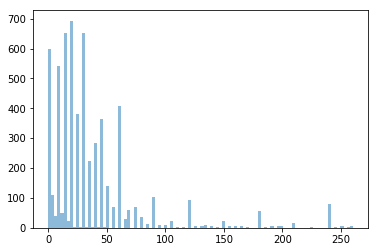

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

plt.hist(asd['cook_time'],bins=100, alpha=0.5)

In [126]:
desc=desc.drop(columns=['id', 'authorId', 'servings'])

In [127]:
desc

,prep_time,cook_time,ready_in_time,rating,rating_count,review_count,made_it_count
mean,17.10,59.21,109.30,4.36,252.94,189.32,372.13
std,32.04,105.29,253.23,0.28,490.71,353.85,761.33
min,0.00,0.00,0.00,2.00,2.00,1.00,5.00
max,1500.00,1500.00,10290.00,5.00,7898.00,5588.00,14356.00
50%,15.00,30.00,50.00,4.40,105.00,82.00,142.50


In [128]:
index = desc.index
index_list = index.tolist()
index_list[4] = 'median'
index_list[4] 
desc.index = index_list

'median'

In [129]:
desc = desc.reindex(['mean', 'median', 'std', 'min', 'max'])

In [130]:
desc

,prep_time,cook_time,ready_in_time,rating,rating_count,review_count,made_it_count
mean,17.10,59.21,109.30,4.36,252.94,189.32,372.13
median,15.00,30.00,50.00,4.40,105.00,82.00,142.50
std,32.04,105.29,253.23,0.28,490.71,353.85,761.33
min,0.00,0.00,0.00,2.00,2.00,1.00,5.00
max,1500.00,1500.00,10290.00,5.00,7898.00,5588.00,14356.00


In [131]:
# setze multiinde auf 'id' und 'ingredients_id'
ingredients = ing.set_index(['id', 'ingredients_id'])

In [132]:
ingredients

ingredients_name  \
id     ingredients_id                                                      
59661  16157                                                 10 g butter   
       4405                                     40 g sliced green onions   
       4342                                  1-1/2 cloves garlic, minced   
       4520            3/4 (10 ounce) package frozen chopped spinach ...   
       16243                                        180 g ricotta cheese   
...                                                                  ...   
244188 20551                                            1 g ground cumin   
       16403                                         0.8 g dried oregano   
       16406                             1 g freshly ground black pepper   
       6307                                              15 ml olive oil   
       6527                      570 g skinless, boneless chicken thighs   

                       ingredients_grams ingredients_type  
id     ingredients_id                                      
59661  16157                       11.36           Normal  
       4405                        41.80           Normal  
       4342                         4.80           Normal  
       4520                       227.20           Normal  
       16243                      182.40           Normal  
...                                  ...              ...  
244188 20551                        1.05           Normal  
       16403                        0.75           Normal  
       16406                        1.05           Normal  
       6307                        13.50           Normal  
       6527                       567.50           Normal  

[61194 rows x 3 columns]

In [133]:
asd= ingredients.reset_index().groupby('id')['ingredients_id'].nunique()

In [134]:
asd.describe()

count   6304.00
mean       9.43
std        3.59
min        1.00
25%        7.00
50%        9.00
75%       12.00
max       26.00
Name: ingredients_id, dtype: float64

In [135]:
ingredients

ingredients_name  \
id     ingredients_id                                                      
59661  16157                                                 10 g butter   
       4405                                     40 g sliced green onions   
       4342                                  1-1/2 cloves garlic, minced   
       4520            3/4 (10 ounce) package frozen chopped spinach ...   
       16243                                        180 g ricotta cheese   
...                                                                  ...   
244188 20551                                            1 g ground cumin   
       16403                                         0.8 g dried oregano   
       16406                             1 g freshly ground black pepper   
       6307                                              15 ml olive oil   
       6527                      570 g skinless, boneless chicken thighs   

                       ingredients_grams ingredients_type  
id     ingredients_id                                      
59661  16157                       11.36           Normal  
       4405                        41.80           Normal  
       4342                         4.80           Normal  
       4520                       227.20           Normal  
       16243                      182.40           Normal  
...                                  ...              ...  
244188 20551                        1.05           Normal  
       16403                        0.75           Normal  
       16406                        1.05           Normal  
       6307                        13.50           Normal  
       6527                       567.50           Normal  

[61194 rows x 3 columns]

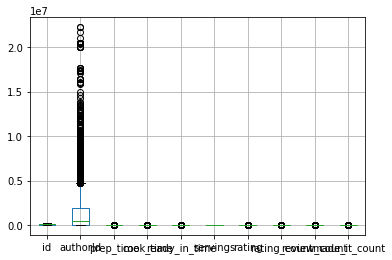

In [136]:
norm_data.boxplot()

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([6.61996882e-04, 2.19965570e-05, 7.73748235e-06, 2.32124470e-06,
        1.54749647e-06, 4.42141848e-07, 3.31606386e-07, 2.21070924e-07,
        1.10535462e-07, 1.10535462e-07]),
 array([5.00000e+00, 1.44010e+03, 2.87520e+03, 4.31030e+03, 5.74540e+03,
        7.18050e+03, 8.61560e+03, 1.00507e+04, 1.14858e+04, 1.29209e+04,
        1.43560e+04]),
 <a list of 10 Patch objects>)

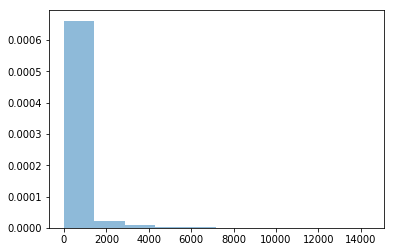

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

plt.hist(norm_data['made_it_count'], normed=True, alpha=0.5)

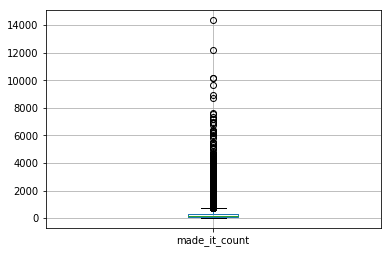

In [138]:
boxplot = norm_data.boxplot(column=[
    'made_it_count'])

In [139]:
norm_data.made_it_count[norm_data.made_it_count == 25583]

Series([], Name: made_it_count, dtype: int64)

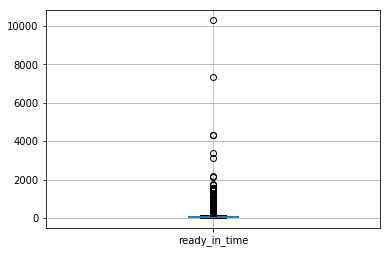

In [140]:
import matplotlib.pyplot as plt



norm_data.boxplot(['ready_in_time'])
                   
    

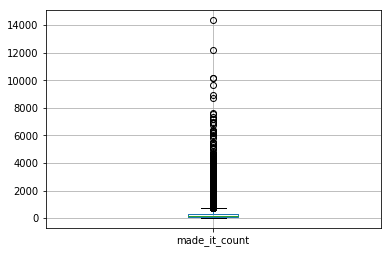

In [141]:
norm_data.boxplot(['made_it_count'])


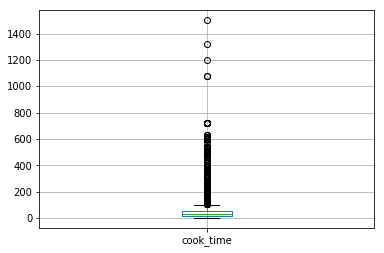

In [142]:
norm_data.boxplot(['cook_time'])

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x147a9edd0>,
      dtype=object)

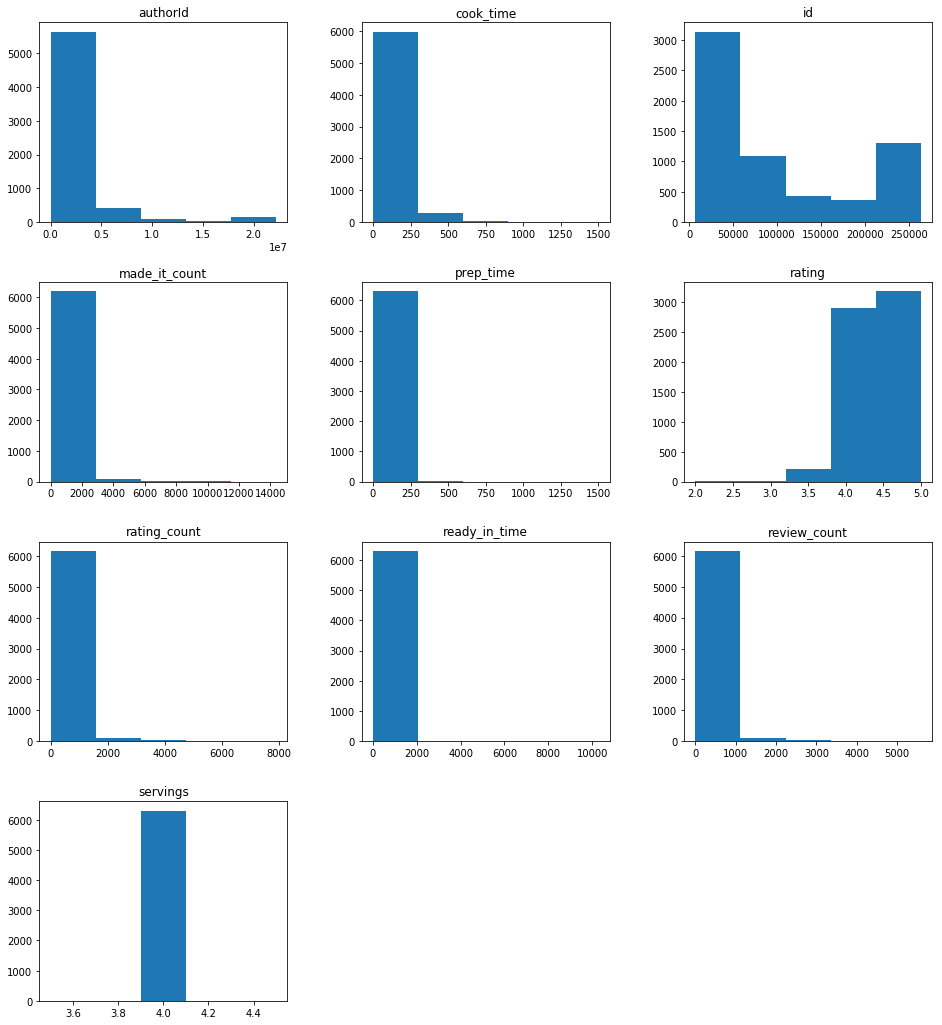

In [143]:
norm_data.hist(bins= 5, grid= 'false', figsize = (16,18))